# DQN v2

#### This version implements DQN using a custom enviroment 

In [ ]:
# !pip install talib-binary
# !pip install yfinance

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
import gym
from gym import spaces
from gym.utils import seeding
from gym import wrappers

from tqdm.notebook import tqdm
from collections import deque
import numpy as np
import random
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import joblib
import talib as ta
import yfinance as yf
import pandas as pd

import io
import base64
from IPython.display import HTML, Video


2022-12-27 23:42:40.080325: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.



In [18]:
class DQN:
    def __init__(self, env=None, replay_buffer_size=1000):
        self.replay_buffer = deque(maxlen=replay_buffer_size)

        self.action_size = env.action_space.n

        # Hyperparameters
        self.gamma = 0.95           # Discount rate
        self.epsilon = 1.0          # Exploration rate
        self.epsilon_min = 0.001      # Minimal exploration rate (epsilon-greedy)
        self.epsilon_decay = 0.95    # Decay rate for epsilon
        self.update_rate = 5       # Number of steps until updating the target network
        self.batch_size = 200
        self.learning_rate = 1e-4
        
        # Construct DQN models
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.target_model.set_weights(self.model.get_weights())
        self.model.summary()
        self.env = env

        self.history = []
        self.scaler = None

    def _build_model(self):
        model = tf.keras.Sequential()
        
        model.add(tf.keras.Input(shape=(4,)))
        model.add(layers.Dense(256, activation = 'relu'))
        model.add(layers.Dense(128, activation = 'relu'))
        model.add(layers.Dense(64, activation = 'relu'))
        model.add(layers.Dense(self.action_size, activation = 'linear'))
        
        optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        model.compile(loss='mse', optimizer=optimizer, metrics = ['mse'])
        return model


    #
    # Trains the model using randomly selected experiences in the replay memory
    #
    def _train(self):
        X, y = [], []
        # state, action, reward, next_state, done 
        # create the targets 
        if self.batch_size > len(self.replay_buffer):
            return
        minibatch = random.sample(self.replay_buffer, self.batch_size)
        mb_arr = np.array(minibatch, dtype=object)

        next_state_arr = np.stack(mb_arr[:,3])
        future_qvalues = self.target_model.predict(next_state_arr, verbose=0)

        state_arr = np.stack(mb_arr[:,0])
        qvalues = self.model.predict(state_arr, verbose=0)

        for index, (state, action, reward, next_state, done) in enumerate(minibatch):
            if done == True:
                q_target = reward
            else:
                q_target = reward + self.gamma * np.max(future_qvalues[index])

            q_curr = qvalues[index]
            q_curr[action] = q_target                
            X.append(state)
            y.append(q_curr)

        # Perform gradient step
        X, y = np.array(X), np.array(y)
        history = self.model.fit(X, y, batch_size = self.batch_size, shuffle = False, verbose=0)
        self.history.append(history.history['loss'])
        # history = self.model.fit(X, y, epochs=1, verbose=0)
        # print(f"Loss: {history.history['loss']}  ")


    def learn(self, total_steps=None):
        current_episode = 0
        total_reward = 0
        rewards = [0]
        current_step = 0
        while current_step < total_steps:
            current_episode += 1
            state = self.env.reset()
            total_reward = 0
            done = False
            while done != True:
                current_step +=1
                # e-greedy
                if np.random.random() > (1 - self.epsilon):
                    action = np.random.randint(self.action_size)
                    # print("Rand action",action)
                else:
                    model_predict = self.model.predict(np.array([state]), verbose=0)
                    action = np.argmax(model_predict)
                    # print("model action",action)

                # step
                next_state, reward, done, info = self.env.step(action)
                total_reward += reward

                # add to buffer
                self.replay_buffer.append((state, action, reward, next_state, done))

                if current_step>10 and current_step % self.update_rate == 0:
                    hist=None
                    if len(self.history) > 0:
                        hist = self.history[-1]
                    print(f"epsilon:{self.epsilon} step:{current_step} episode:{current_episode} last_score {rewards[-1]} Profit {info['total_profit']} Loss {hist}")
                    self._train()
                    # update target
                    self.target_model.set_weights(self.model.get_weights())
                
                state = next_state

                # update epsilon 
                if current_step % 20 == 0:
                    if self.epsilon > self.epsilon_min:
                        self.epsilon *= self.epsilon_decay

            rewards.append(total_reward)

    #
    # Loads a saved model
    #
    def load(self, name):
        self.model = tf.keras.models.load_model(name)
        # self.scaler = joblib.load(name+".scaler") 

    #
    # Saves parameters of a trained model
    #
    def save(self, name):
        self.model.save(name)
        # joblib.dump(self.scaler, name+".scaler") 

    def play(self, state):
        # state = self._get_scaled_state(state)
        return np.argmax(self.model.predict(np.array([state]), verbose=0)[0])

In [47]:
from enum import Enum
class Actions(Enum):
    Sell = 0
    Buy = 1
    Do_nothing = 2

class CustTradingEnv(gym.Env):

    def __init__(self, df, max_steps=0, seed=8, random_start=True, scaler=None):
        self.seed(seed=seed)
        self.df = df
        if scaler is None:
            self.scaler = MinMaxScaler()
        else:
            self.scaler = scaler
        self.prices, self.signal_features = self._process_data()

        # spaces
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Box(low=0, high=1, shape=(1,) , dtype=np.float64)

        # episode
        self._start_tick = 0
        self._end_tick = 0
        self._done = None
        self._current_tick = None
        self._last_trade_tick = None
        self._position = None
        self._position_history = None
        self._total_reward = None
        self._total_profit = None
        self._first_rendering = None
        self.history = None
        self._max_steps = max_steps
        self._start_episode_tick = None
        self._trade_history = None
        self._random_start = random_start


    def reset(self):
        self._done = False
        if self._random_start:
            self._start_episode_tick = np.random.randint(1,high=len(self.df)- self._max_steps )
            self._end_tick = self._start_episode_tick + self._max_steps
        else:
            self._start_episode_tick = 1
            self._end_tick = len(self.df)-1

        self._current_tick = self._start_episode_tick
        self._last_trade_tick = self._current_tick - 1
        self._position = 0
        self._position_history = []
        # self._position_history = (self.window_size * [None]) + [self._position]
        self._total_reward = 0.
        self._total_profit = 0.
        self._trade_history = []
        self.history = {}
        return self._get_observation()


    def step(self, action):
        self._done = False
        self._current_tick += 1

        if self._current_tick == self._end_tick:
            self._done = True

        step_reward = self._calculate_reward(action)
        self._total_reward += step_reward

        observation = self._get_observation()
        info = dict(
            total_reward = self._total_reward,
            total_profit = self._total_profit,
            position = self._position,
            action = action
        )
        self._update_history(info)

        return observation, step_reward, self._done, info

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]
        
    def _get_observation(self):
        return self.signal_features[self._current_tick]

    def _update_history(self, info):
        if not self.history:
            self.history = {key: [] for key in info.keys()}

        for key, value in info.items():
            self.history[key].append(value)


    def render(self, mode='human'):
        window_ticks = np.arange(len(self._position_history))
        prices = self.prices[self._start_episode_tick:self._end_tick+1]
        plt.plot(prices)

        open_buy = []
        close_buy = []
        open_sell = []
        close_sell = []
        do_nothing = []

        for i, tick in enumerate(window_ticks):
            if self._position_history[i] == 1:
                open_buy.append(tick)
            elif self._position_history[i] == 2 :
                close_buy.append(tick)
            elif self._position_history[i] == 3 :
                open_sell.append(tick)
            elif self._position_history[i] == 4 :
                close_sell.append(tick)
            elif self._position_history[i] == 0 :
                do_nothing.append(tick)

        plt.plot(open_buy, prices[open_buy], 'go', marker="^")
        plt.plot(close_buy, prices[close_buy], 'go', marker="v")
        plt.plot(open_sell, prices[open_sell], 'ro', marker="v")
        plt.plot(close_sell, prices[close_sell], 'ro', marker="^")
    
        plt.plot(do_nothing, prices[do_nothing], 'yo')

        plt.suptitle(
            "Total Reward: %.6f" % self._total_reward + ' ~ ' +
            "Total Profit: %.6f" % self._total_profit
        )

    def _calculate_reward(self, action):
        step_reward = 0

        current_price = self.prices[self._current_tick]
        last_price = self.prices[self._current_tick - 1]
        price_diff = current_price - last_price

        penalty = -1 * last_price * 0.01
        # OPEN BUY - 1
        if action == Actions.Buy.value and self._position == 0:
            self._position = 1
            step_reward += price_diff
            self._last_trade_tick = self._current_tick - 1
            self._position_history.append(1)

        elif action == Actions.Buy.value and self._position > 0:
            step_reward += penalty
            self._position_history.append(-1)
        # CLOSE SELL - 4
        elif action == Actions.Buy.value and self._position < 0:
            self._position = 0
            step_reward += -1 * (self.prices[self._current_tick -1] - self.prices[self._last_trade_tick]) 
            self._total_profit += step_reward
            self._position_history.append(4)
            self._trade_history.append(step_reward)

        # OPEN SELL - 3
        elif action == Actions.Sell.value and self._position == 0:
            self._position = -1
            step_reward += -1 * price_diff
            self._last_trade_tick = self._current_tick - 1
            self._position_history.append(3)
        # CLOSE BUY - 2
        elif action == Actions.Sell.value and self._position > 0:
            self._position = 0
            step_reward += self.prices[self._current_tick -1] - self.prices[self._last_trade_tick] 
            self._total_profit += step_reward
            self._position_history.append(2)
            self._trade_history.append(step_reward)
        elif action == Actions.Sell.value and self._position < 0:
            step_reward += penalty
            self._position_history.append(-1)

        # DO NOTHING - 0
        elif action == Actions.Do_nothing.value and self._position > 0:
            step_reward += price_diff
            self._position_history.append(0)
        elif action == Actions.Do_nothing.value and self._position < 0:
            step_reward += -1 * price_diff
            self._position_history.append(0)
        elif action == Actions.Do_nothing.value and self._position == 0:
            step_reward += -1 * abs(price_diff)
            self._position_history.append(0)

        step_reward = step_reward/10
        return step_reward

    def get_scaler(self):
        return self.scaler

    def set_scaler(self, scaler):
        self.scaler = scaler
 
    def _process_data(self):
        timeperiod = 14
        self.df = self.df.copy()
        
        self.df['mfi_r'] = ta.MFI(self.df['High'], self.df['Low'], self.df['Close'],self.df['Volume'], timeperiod=timeperiod)
        _, self.df['stoch_d_r'] = ta.STOCH(self.df['High'], self.df['Low'], self.df['Close'], fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
        self.df['adx_r'] = ta.ADX(self.df['High'], self.df['Low'], self.df['Close'], timeperiod=timeperiod)
        self.df['p_di'] = ta.PLUS_DI(self.df['High'], self.df['Low'], self.df['Close'], timeperiod=timeperiod)
        self.df['m_di'] = ta.MINUS_DI(self.df['High'], self.df['Low'], self.df['Close'], timeperiod=timeperiod)
        self.df['di'] = np.where( self.df['p_di'] > self.df['m_di'], 1, 0)

        self.df = self.df.dropna()
        # self.df['di_s']=self.df['di']
        # self.df['mfi_s']=self.df['mfi_r']
        # self.df['stoch_d_s']=self.df['stoch_d_r']
        # self.df['adx_s']=self.df['adx_r']

        self.df[['di_s','mfi_s','stoch_d_s','adx_s']] = self.scaler.fit_transform(self.df[['di','mfi_r','stoch_d_r','adx_r']])

        def f1(row):
            row['state'] = [row['di_s'], row['mfi_s'], row['stoch_d_s'], row['adx_s']]
            return row

        self.df = self.df.apply(f1, axis=1 )

        prices = self.df.loc[:, 'Close'].to_numpy()
        # print(self.df.head(30))

        signal_features = np.stack(self.df.loc[:, 'state'].to_numpy())

        return prices, signal_features

In [48]:
# Get data
eth_usd = yf.Ticker("ETH-USD")
eth = eth_usd.history(period="max")

btc_usd = yf.Ticker("BTC-USD")
btc = btc_usd.history(period="max")
print(len(btc))
print(len(eth))

btc_train = eth[-3015:-200]
# btc_test = eth[-200:]
eth_train = eth[-1864:-200]
eth_test = eth[-200:]
# len(eth_train)

3025
1876


In [49]:
# create env
max_steps = 20  
env = CustTradingEnv(df=eth_train, max_steps=max_steps)

model = DQN(env=env, replay_buffer_size=10_000)
model.learn(total_steps=6_000)


Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_104 (Dense)           (None, 256)               1280      
                                                                 
 dense_105 (Dense)           (None, 128)               32896     
                                                                 
 dense_106 (Dense)           (None, 64)                8256      
                                                                 
 dense_107 (Dense)           (None, 3)                 195       
                                                                 
Total params: 42,627
Trainable params: 42,627
Non-trainable params: 0
_________________________________________________________________
epsilon:1.0 step:15 episode:1 last_score 0 Profit 26.009002685546875 Loss None
epsilon:1.0 step:20 episode:1 last_score 0 Profit 26.009002685546875 Loss None
epsilon:0.95 step:25 ep

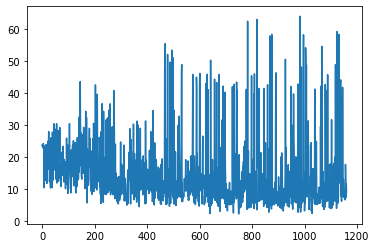

1161

In [50]:
plt.plot(model.history)
plt.show()
len(model.history)

In [40]:
model.save("./alt/fin_rl_dqn_v1")
joblib.dump(env.get_scaler(),"./alt/fin_rl_dqn_v1.h5_scaler")


INFO:tensorflow:Assets written to: ./alt/fin_rl_dqn_v1/assets


['./alt/fin_rl_dqn_v1.h5_scaler']

In [55]:


def evaluate_agent(env, max_steps, n_eval_episodes, model, random=False):
  """
  Evaluate the agent for ``n_eval_episodes`` episodes and returns average reward and std of reward.
  :param env: The evaluation environment
  :param n_eval_episodes: Number of episode to evaluate the agent
  :param model: The DQN model
  """
  episode_rewards = []
  episode_profits = []
  for episode in tqdm(range(n_eval_episodes), disable=random):
    state = env.reset()
    step = 0
    done = False
    total_rewards_ep = 0
    total_profit_ep = 0
    
    for step in range(max_steps):
      # Take the action (index) that have the maximum expected future reward given that state
      if random:
        action = env.action_space.sample()
      else:
        action = model.play(state)
    #   print(action)
        
      new_state, reward, done, info = env.step(action)
      total_rewards_ep += reward
        
      if done:
        break
      state = new_state

    episode_rewards.append(total_rewards_ep)
    episode_profits.append(env.history['total_profit'][-1])
    # print(env.history)
    # env.render()
    # assert 0

  mean_reward = np.mean(episode_rewards)
  std_reward = np.std(episode_rewards)
  mean_profit = np.mean(episode_profits)
  std_profit = np.std(episode_profits)

  return mean_reward, std_reward, mean_profit, std_profit

In [42]:
max_steps = 20 
env_test = CustTradingEnv(df=eth_test, max_steps=max_steps, random_start=True, scaler=env.get_scaler())
n_eval_episodes = 1000

evaluate_agent(env_test, max_steps, n_eval_episodes, model)

  0%|          | 0/1000 [00:00<?, ?it/s]

(-27.732505046264645, 7.941349490500967, 0.0, 0.0)

In [56]:
# trade sequentially 
max_steps = len(eth_test)
env_test = CustTradingEnv(df=eth_test, max_steps=max_steps, random_start=False, scaler=env.get_scaler())
n_eval_episodes = 1

evaluate_agent(env_test, max_steps, n_eval_episodes, model)

  0%|          | 0/1 [00:00<?, ?it/s]

(-213.00087292480464, 0.0, 255.009033203125, 0.0)

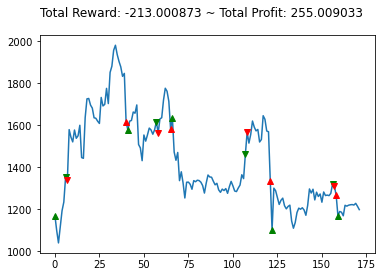

In [53]:
env_test.render()

In [81]:
# load model and scaler from file
max_steps = 20 
scaler_l = joblib.load("./alt/fin_rl_dqn_v1.h5_scaler")
env_l = CustTradingEnv(df=eth_test, max_steps=max_steps, scaler=scaler_l, random_start=False)

model_l = DQN(env=env_l, replay_buffer_size=10_000)
model_l.load("./alt/fin_rl_dqn_v1")

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_72 (Dense)            (None, 256)               1280      
                                                                 
 dense_73 (Dense)            (None, 128)               32896     
                                                                 
 dense_74 (Dense)            (None, 64)                8256      
                                                                 
 dense_75 (Dense)            (None, 3)                 195       
                                                                 
Total params: 42,627
Trainable params: 42,627
Non-trainable params: 0
_________________________________________________________________


In [82]:
# trade sequentially the loaded model and env
max_steps = len(eth_test)
n_eval_episodes = 1
evaluate_agent(env_l, max_steps, n_eval_episodes, model_l)

  0%|          | 0/1 [00:00<?, ?it/s]

(-1782.8878674316418, 0.0, 381.1708984375, 0.0)

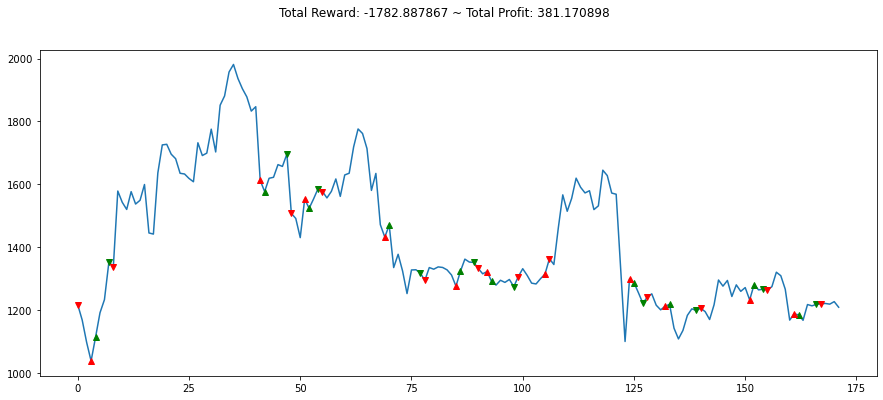

In [86]:
plt.figure(figsize=(15,6))
plt.cla()
env_l.render()


In [84]:
# Test for random n_eval_episodes
max_steps = 20 
env_test_rand = CustTradingEnv(df=eth_test, max_steps=max_steps, random_start=True, scaler=env.get_scaler())
n_eval_episodes = 1000

evaluate_agent(env_test_rand, max_steps, n_eval_episodes, model, random=True)

(-156.66986416870117,
 394.94783990529805,
 4.957175903320312,
 211.59187866264426)

In [85]:
# trade sequentially with random actions 
max_steps = len(eth_test)
env_test = CustTradingEnv(df=eth_test, max_steps=max_steps, random_start=False, scaler=env.get_scaler())
n_eval_episodes = 1

all_profit=[]
for i in range(1000):
    _,_,profit,_=evaluate_agent(env_test, max_steps, n_eval_episodes, model, random=True)
    all_profit.append(profit)
print(f"Mean profit {np.mean(all_profit)}")

Mean profit 3.7792178955078124


## Results

| Model      | 1000 trades 20 steps | Sequential trading | 1000 trades 20 steps random actions | Sequential random|
|------------|----------------------|--------------------|-------------------------------------|------------------|
|Q-learning  | 113.14               | 563.67             | -18.10                              | 39.30            |
|DQN         | 87.62                | 381.17             | 4.95                                | 3.77             |


#### Actions are: Buy/Sell/Hold 1 ETH 
1000 trades 20 steps - Made 1000 episodes, 20 trades each episode, result is the mean return of each episode 

Sequential trading (175 days)- Trade the test set sequentially from start to end day 

1000 trades 20 steps random actions - Made 1000 episodes, 20 trades each episode taking random actions 

Sequential random (175 days)- Trade the test set sequentially from start to end day with random actions 